# Flatiron School Phase 4 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **1/13/24**

Instructor name: **Mark Barbour**

Blog post URL: **[Measuring the amount of volatility in a time series dataset](https://medium.com/@angelo.turri/measuring-the-amount-of-volatility-in-a-time-series-dataset-ac040a0c87de)**

# INTRODUCTION

### Stakeholder

Our stakeholder is a home-flipper in Michigan. Their aim is to buy properties, keep them for several months, renovate them, and re-sell them for a profit. They want us to give them the best 5 zipcodes to invest in.

### Data: Origin & Usage

The dataset in this project was taken from [this page](https://www.zillow.com/research/data/) and stored on [this github repository](https://github.com/learn-co-curriculum/dsc-phase-4-choosing-a-dataset/tree/main/time-series) as "zillow_data.csv."

After importing and adjusting the dataset so it could be used for modeling, it contained 265 months of data for 13,684 zipcodes, totalling to 3.6 million rows of data.

We condensed the dataset down to just houses in Michigan, and then we condensed it further to houses sold during and after 2012. We chose this time period because the housing market came out of the decline caused by the 2008 housing market crash. We didn't want data from a rare, unlikely event to impact our models.

### Methods Justification & Value to Stakeholder

Our goal was to give our stakeholders the five zipcodes offering the highest ROI while not having volatile house prices. The idea is to provide low-risk, good-reward opportunities for investment.

We use an **iterative modeling process**, meaning we start with a baseline model and make changes to our model based on model performance.

### Limitations

Data before 2012 includes anomalous and low-probability events that can adversely affect model performance (e.g., the 2008 housing market crash). After removing this data, the amount of resulting data is smaller than ideal.

### Metrics

To evaluate model error, we used RMSE (root mean squared error), on both the training and testing data (if a train-test split was used) to gauge model prediction error. Root mean squared error is the average amount a model was off each time it made a prediction.

We measured "overfitting" by how much greater a model's test RMSE was than its train RMSE. If it made worse errors on the test data set, it was overfitting. The worse the errors on average, the worse the overfit.

We used two tests of stationarity, the augmented Dickey–Fuller test and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test, to see whether or a model's residuals were stationary. We used two instead of one because if both tests agree, I am more confident saying the model actually did extract all temporal components from its dataset.

The quality of an investment was determined by:

- the expected ROI (return on investment), which divides the expected home price in 3 months by the latest recorded home price;
- the volatility score of the zipcode. I developed a score for measuring volatility that involves measuring the magnitude of fluctuations in price and normalizing them with the range of values seen in that zipcode's price.
    - The magnitude of fluctuations was given by differencing each zipcode's price differences. This gives the approximate value of the second derivative of the price, which approximates how much the price's slope is changing at any given point.


### Model Evaluation

Our baseline model was a naive model, a good starting point for developing good time-series models. The naive model simply shifts all values forward by one chosen time unit (in this case a month). Each shifted value becomes the model's "prediction" for that month, and its one-month forecast is just the latest recorded value.

Our next model was an ARIMA model with an order of (1,1,1). The parameters for this model were informed by ACF (autocorrelation function) and PACF (partial autocorrelation function) plots for the Michigan sales data. This model's performance increased on the training data. However, overfitting also increased.

In our next round of modeling, we improved model performance by using a rolling forecast instead. A rolling forecast makes a prediction, appends that prediction to its training data, and re-trains itself on the updated training data to make its next prediction. Using a rolling forecast slightly improved model performance by decreasing the amount of overfitting.

For our final model, we threw out the train-test-split, as this split was only used to gauge overfitting. 
When making your final predictions, you want to use all the data available to you. Because the rolling ARIMA forecast was the least overfitting model, we trained that model on all our available time series data and used it to make predictions 3 months into the future.

After making these predictions, we knew the potential ROI for each zipcode, but we did not know how volatile each zipcode was. Looking at each zipcode manually is time-consuming; ideally, we would have a way of scoring each zipcode's volatility. I developed a score for measuring volatility that involves measuring the magnitude of fluctuations in price and normalizing them with the range of values seen in that zipcode's price.

Utilizing this scoring method, I narrowed down Michigan's zipcodes to a list of low-volatility zipcodes (volatility score <5), and from that list, I selected the zipcodes that yielded the highest ROI. These zipcodes were recommended to the stakeholder. They are:

[zipcode – state – county – city  average home price – expected ROI]

# Helper functions

In [1]:
def get_volatility(series):
    
    """
    A relatively simple function that gauges the amount
    of volatility in a dataset. It:
    
    1) uses the magnitude of the slope changes in the dataset 
    (the values of the second derivative)
    
    2) squares them to avoid negative values cancelling out positive
    values, and penalize greater changes at the same time
    
    3) Averages the squared changes
    
    4) Divides the average squared change by the range of the dataset
    and the length of the dataset to normalize it
    """
    
    changes = series.diff(1).diff(1)
    squared_changes = changes.map(lambda x: x**2)
    mean_squared_change = squared_changes.mean()
    rng = series.max() - series.min()
    return (mean_squared_change/rng)

In [2]:
def ad_pvalue(dataframe):
    """
    Performs an augmented dickey-fuller test on some data,
    and returns the pvalue.
    """
    dftest = adfuller(dataframe)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput['p-value']

def kpss_pvalue(dataframe):
    """
    Performs a Kwiatkowski–Phillips–Schmidt–Shin test on some data,
    and returns the pvalue.
    """
    kpsstest = kpss(dataframe, regression='ct')
    return kpsstest[1]

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time', inplace=True)
    return melted

# Importing packages and data

In [4]:
# Importing packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display_html
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [5]:
# Importing data
data = pd.read_csv('data/zillow_data.csv')

In [6]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [7]:
# Changing from wide to long format
df = melt_data(data)

# Making sure each zipcode in the dataset has the full 265 months of data
df['zipcount'] = df['RegionName'].map(df.RegionName.value_counts())
df = df[df.zipcount==265]

# Changing the name of the zipcode column from "RegionName" to "zipcode", because that's what it is
df['zipcode'] = df['RegionName']
df.drop(['RegionName'], axis=1, inplace=True)

In [8]:
# Limiting dataset to just houses in Michigan
michigan = df.query("State=='MI'")

# General trend of house price data

You can see the effects of the 2008 housing market crash on what was an otherwise ever-increasing series of data points. This crash was an anomaly in the general upward trend of housing prices. I didn't want a rare and unlikely occurrence to adversely affect my model predictions, so I only kept data after 2012, which is when the housing market slump seemed to be over.

In [9]:
grouped = michigan.groupby('time').aggregate({'value':'mean'})

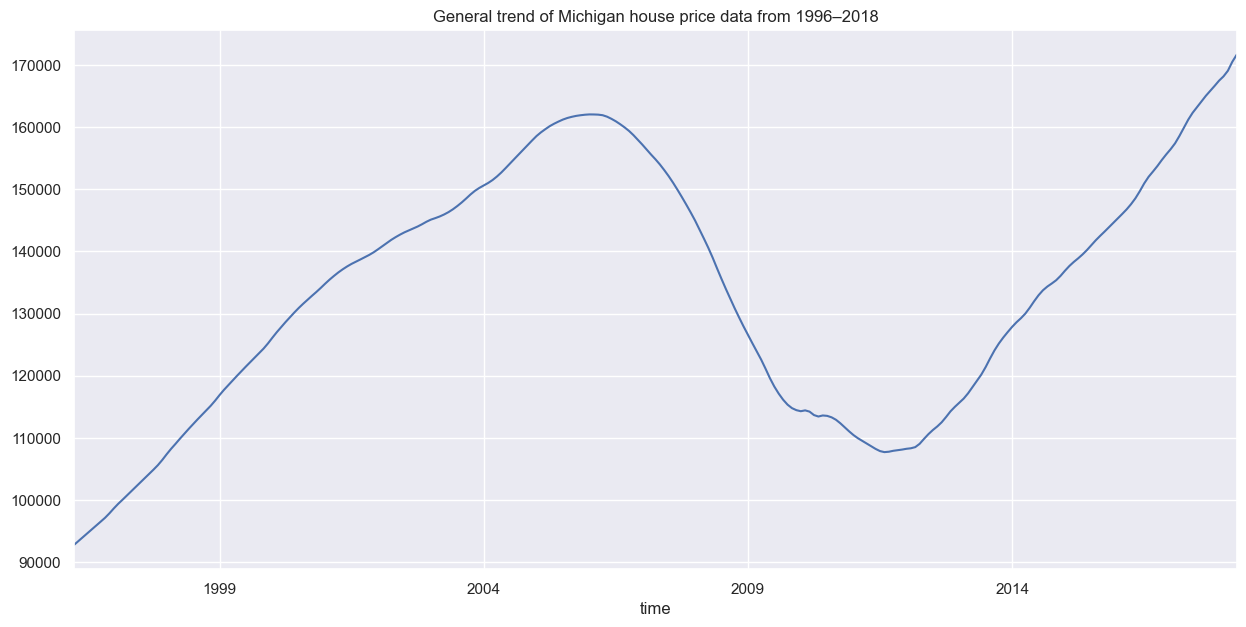

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()
ax.set_title("General trend of Michigan house price data from 1996–2018");

# Data after the housing market crash

As expected, we have removed the anomalous housing market crash and what remains is a normal, linearly trending group of data for housing prices. This is the data that we will use for our models.

In [11]:
# Keeping data during and after 2012
ad_2012 = michigan[michigan.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

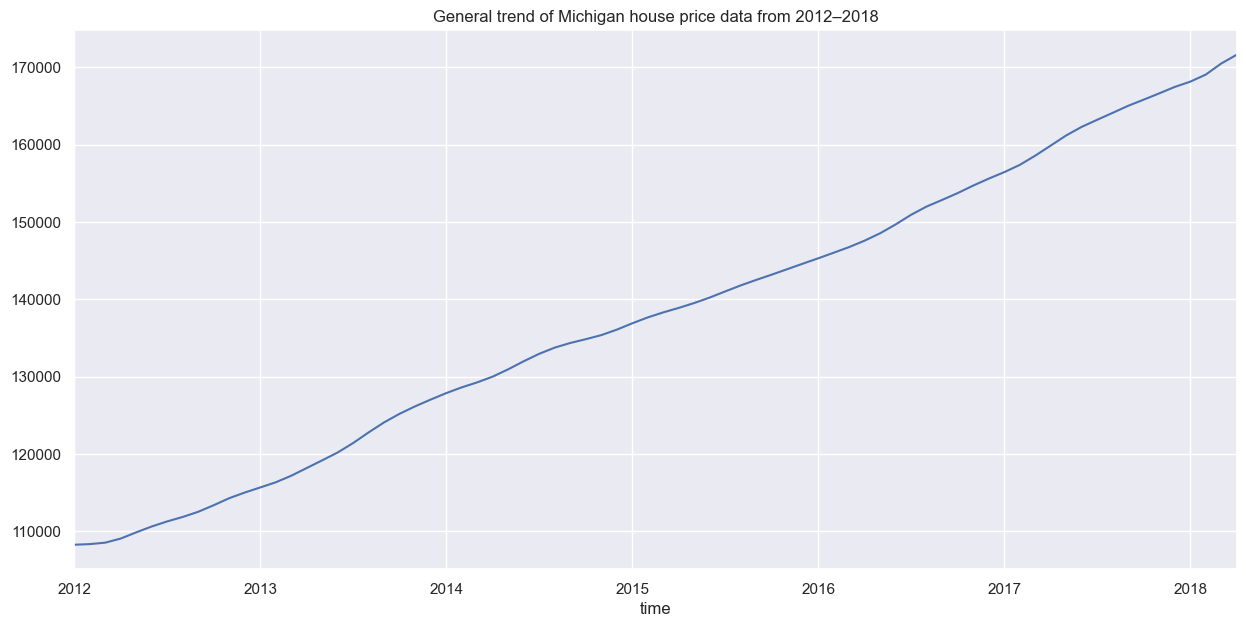

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()
ax.set_title("General trend of Michigan house price data from 2012–2018");

# Number of zipcodes

Our stakeholder wants us to examine all the zipcodes in the dataset. To find out which zipcodes are the best ones to invest in, we will have to forecast housing prices in each zipcode, which means fitting at least one model to each. ARIMA and SARMIAX do not take categorical exogenous variables, only numerical ones, which excludes the zipcode variable from being included in either type of model.

In [13]:
df.dtypes

RegionID        int64
SizeRank        int64
City           object
State          object
Metro          object
CountyName     object
value         float64
zipcount        int64
zipcode         int64
dtype: object

In [14]:
df.zipcode.nunique()

13684

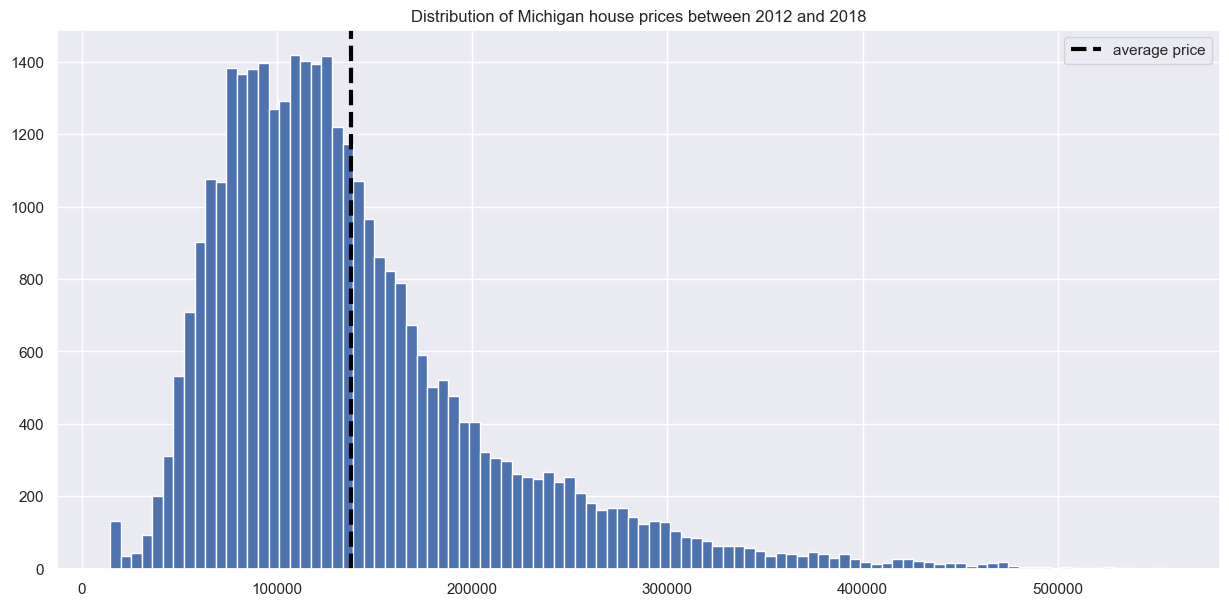

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(ad_2012.value, bins=100)
ax.set_title("Distribution of Michigan house prices between 2012 and 2018")
ax.axvline(x=ad_2012.value.mean(), lw=3, linestyle='--', c='black', label='average price')
ax.legend();

# Kinds of zipcodes

Although the aggregated dataset shows a clear upwards trend, not all zipcodes follow this pattern. There are zipcodes that follow a very linear upward trajectory, but there are others that follow a more volatile path.

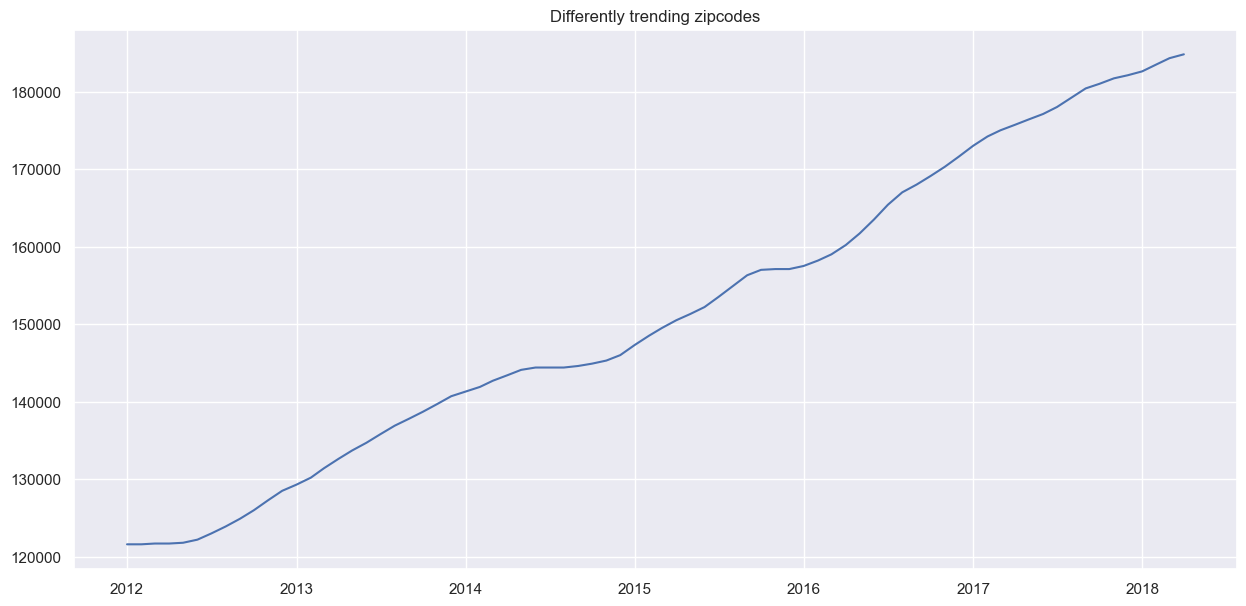

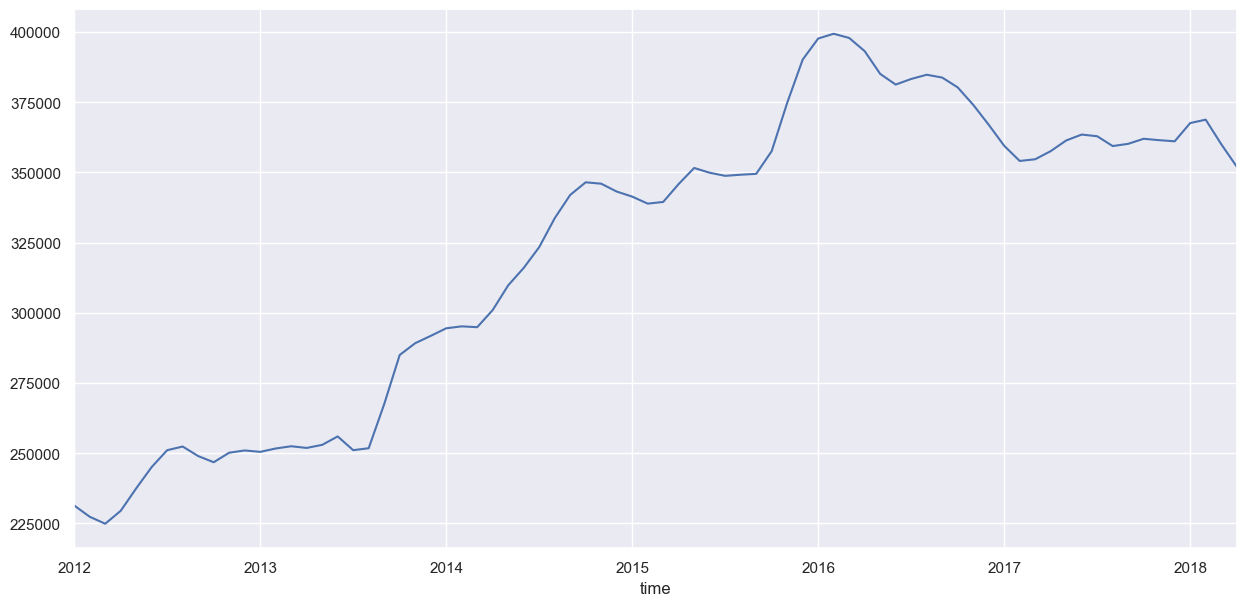

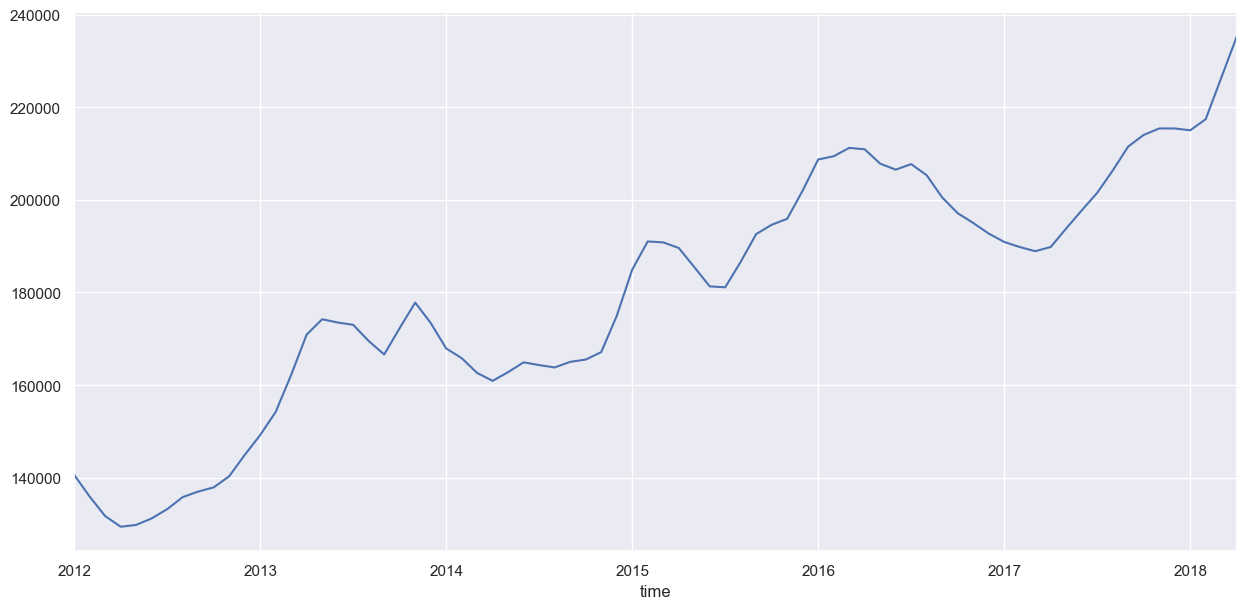

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Differently trending zipcodes")
ax.plot(ad_2012[ad_2012.zipcode==49428].value)

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==49129].value.plot()

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==49060].value.plot();

# Naive Models

The baseline naive model we will use is a model with all values shifted forward by 1. We will perform a train-test-split on the dataset.

A successful model will successfully extract all temporal components from each zipcode's time series, and the accompanying model residuals will be stationary.

In [17]:
st = time.time()

ad_pvalues, kpss_pvalues = [], []
residuals_list = []
train_preds, test_preds = [], []
train_rmses, test_rmses = [], []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    # Splits data into train and test sets along the 
    # end of 2016.
    train = zipcode[zipcode.index<'2017-01-01'][1:]
    test = zipcode[zipcode.index>'2016-12-01']
    trains.append(train)
    tests.append(test)
    
    # After shifting, the first value will be null,
    # so this value is eliminated from the set.
    shifted = zipcode.shift(1)[1:]
    
    # Divides the predictions into those for the
    # train/test set.
    trainps = shifted[:59]
    testps = shifted[59:]
    train_preds.append(trainps)
    test_preds.append(testps)
    
    # Performing the root mean squared error for both test
    # and train datasets.
    train_rmse = mean_squared_error(train, trainps, squared=False)
    test_rmse = mean_squared_error(test, testps, squared=False)
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    
    residuals = trainps-train
    residuals_list.append(residuals)
    
    # Two statistical tests, the adfuller and the kpss test,
    # are performed on the model residuals (errors).
    # Having two separate tests agree on stationarity is better
    # than only using one.
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    # Helpful ticker
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 1.5769288539886475 seconds


In [18]:
# Uses the results from the loop to make a dataframe for easy analysis.
naive_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'train_rmse': train_rmses, 
                               'test_rmse': test_rmses,
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list, 
                               'train_preds': train_preds, 
                               'test_preds': test_preds, 
                               'train': trains, 
                               'test': tests})

In [19]:
naive_tests_in_agreement = len(naive_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(naive_model_df)
naive_model_train_rmse = round(naive_model_df.train_rmse.mean(), 2)
naive_model_test_rmse = round(naive_model_df.test_rmse.mean(), 2)
naive_difference = round(naive_model_test_rmse / naive_model_train_rmse, 2)

In [20]:
print("\n")
print(f"{round(naive_tests_in_agreement * 100, 2)}% of all naive models are stationary according to both statistical tests.\n")
print(f"The root mean squared error for all naive models on the training dataset is {f'{naive_model_train_rmse:,}.'}\n")
print(f"The root mean squared error for all naive models on the test dataset is {f'{naive_model_test_rmse:,}.'}\n")
print(f"The root mean squared error on the test dataset is {naive_difference} times greater than that for the train dataset.")
print("\n")



47.02% of all naive models are stationary according to both statistical tests.

The root mean squared error for all naive models on the training dataset is 1,284.52.

The root mean squared error for all naive models on the test dataset is 1,464.14.

The root mean squared error on the test dataset is 1.14 times greater than that for the train dataset.




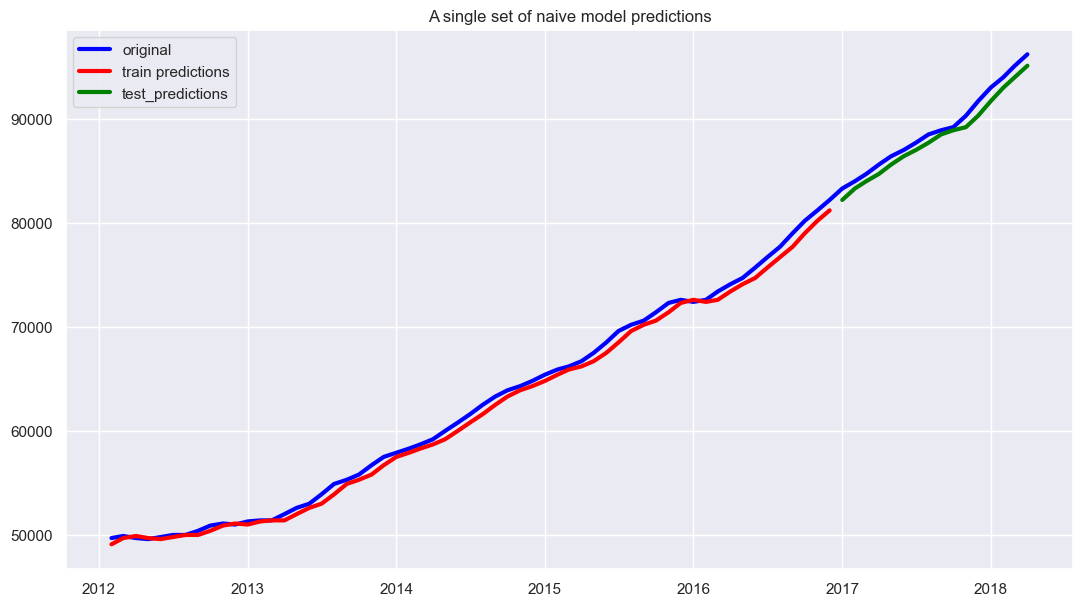

In [21]:
fig, ax = plt.subplots(figsize=(13,7))

row=naive_model_df.iloc[1]
ax.plot(pd.concat([row.train, row.test]), c='blue', label='original', lw='3')
ax.plot(row.train_preds, c='red', label='train predictions', lw='3')
ax.plot(row.test_preds, c='green', label='test_predictions', lw='3')
ax.set_title("A single set of naive model predictions")
ax.legend();

# Deciding our parameters for the ARIMA model

We are moving onto ARIMA models. ARIMA models have three main parameters:

- p: AR term
- d: difference
- q: MA term

Looking at our autocorrelation and partial autocorrelation plots, it looks like we should at least make one difference on the data. Let's perform the difference and then re-evaluate the partial and autocorrelation plots.

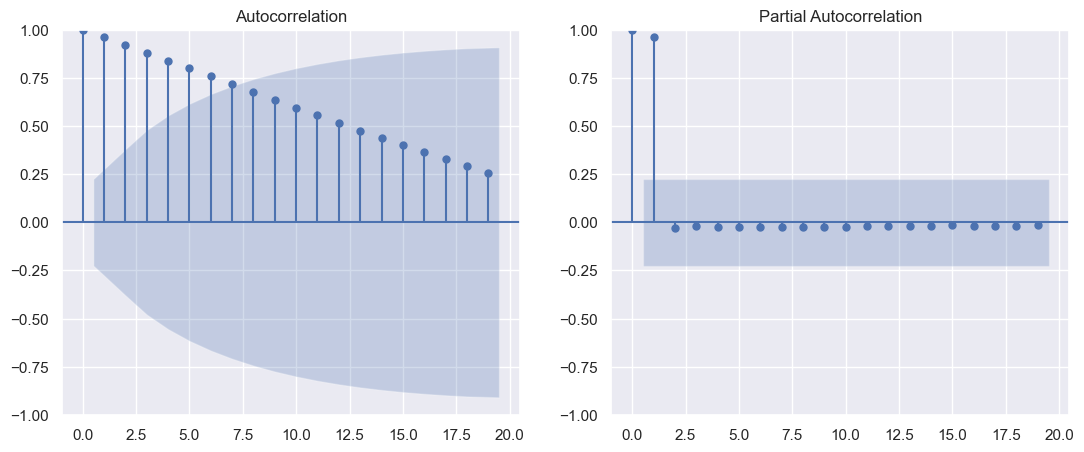

In [22]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

plot_acf(grouped.value, ax=ax[0]);
plot_pacf(grouped.value, ax=ax[1]);

# Differencing the series

After differencing the aggregated series, the number of significant lags went down from 7 to 1. These suggest that our first model should have one AR terms, one MA term, and one difference.

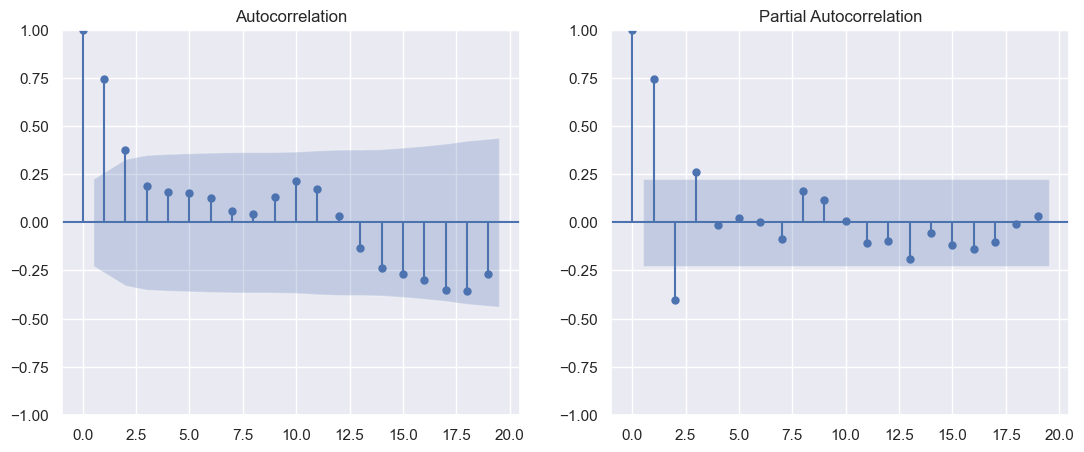

In [23]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

plot_acf(grouped.diff(1).value[1:], ax=ax[0]);
plot_pacf(grouped.diff(1).value[1:], ax=ax[1]);

# ARIMA models
# Order: (1, 1, 1)

In [24]:
st = time.time()

ad_pvalues, kpss_pvalues = [], []
residuals_list = []
train_preds, test_preds = [], []
train_rmses, test_rmses = [], []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    # Splits data into train and test sets along the 
    # end of 2016.
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    trains.append(train[1:])
    tests.append(test)

    # Instantiates, trains, and fits the ARIMA model.
    model = ARIMA(train, order=(1, 1, 1)).fit()
            
    # Divides the predictions into those for the
    # train/test set.
    trainps = model.predict()
    testps = model.get_forecast(steps=16).predicted_mean
    train_preds.append(trainps[1:])
    test_preds.append(testps)
    
    # Performing the root mean squared error for both test
    # and train datasets.
    train_rmse = mean_squared_error(train[1:], trainps[1:], squared=False)
    test_rmse = mean_squared_error(test, testps, squared=False)
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    
    residuals = trainps[1:]-train[1:]
    residuals_list.append(residuals)
    
    # Two statistical tests, the adfuller and the kpss test,
    # are performed on the model residuals (errors).
    # Having two separate tests agree on stationarity is better
    # than only using one.
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    # Helpful ticker
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #453/453 done.
Execution time: 15.075210809707642 seconds


In [25]:
# Uses the results from the loop to make a dataframe for easy analysis.
arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'train_rmse': train_rmses, 
                               'test_rmse': test_rmses,
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list, 
                               'train_preds': train_preds, 
                               'test_preds': test_preds, 
                               'train': trains, 
                               'test': tests})

In [26]:
arima_tests_in_agreement = len(arima_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(arima_model_df)
arima_model_train_rmse = round(arima_model_df.train_rmse.mean(), 2)
arima_model_test_rmse = round(arima_model_df.test_rmse.mean(), 2)
arima_difference = round(arima_model_test_rmse / arima_model_train_rmse, 2)

In [27]:
print("\n")
print(f"{round(arima_tests_in_agreement * 100, 2)}% of all ARIMA models are stationary according to both statistical tests.\n")
print(f"The root mean squared error for all ARIMA models on the training dataset is {f'{arima_model_train_rmse:,}.'}\n")
print(f"The root mean squared error for all ARIMA models on the test dataset is {f'{arima_model_test_rmse:,}.'}\n")
print(f"The root mean squared error on the test dataset is {arima_difference} times greater than that for the train dataset.")
print("\n")



52.54% of all ARIMA models are stationary according to both statistical tests.

The root mean squared error for all ARIMA models on the training dataset is 950.07.

The root mean squared error for all ARIMA models on the test dataset is 5,644.91.

The root mean squared error on the test dataset is 5.94 times greater than that for the train dataset.




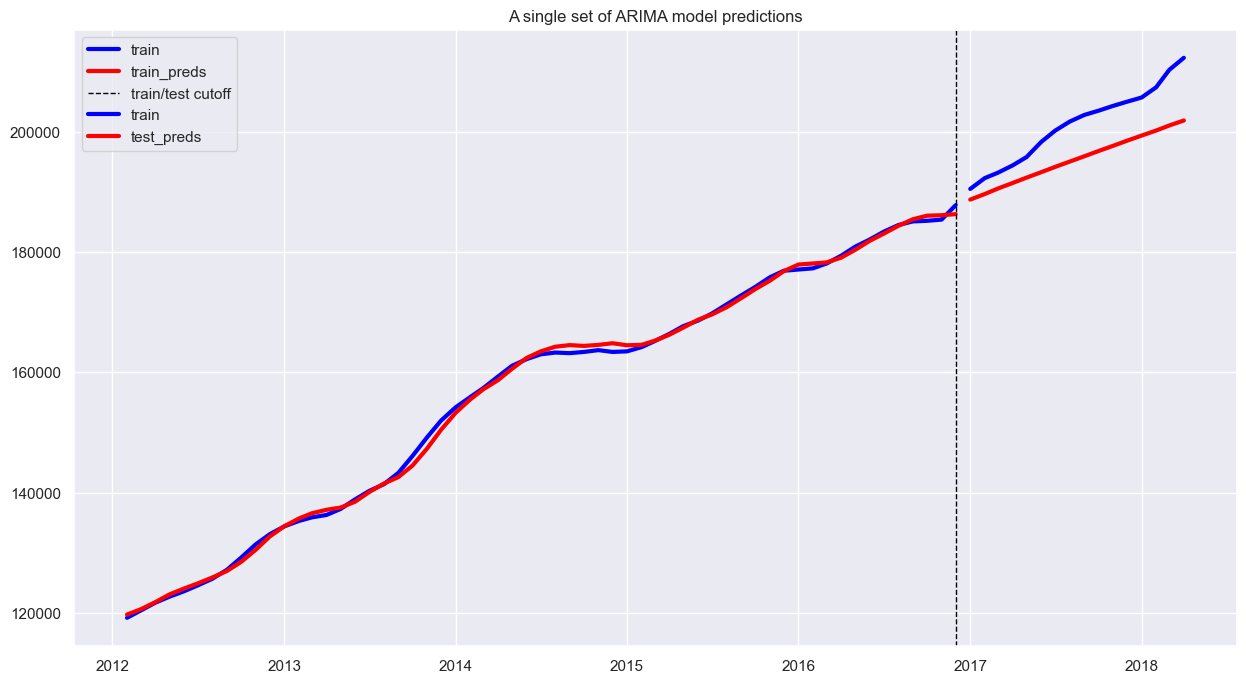

In [28]:
row = arima_model_df.iloc[0]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train', lw='3')
ax.plot(row.train_preds, c='red', label='train_preds', lw='3')
ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')
ax.plot(row.test, c='blue', label='train', lw='3')
ax.plot(row.test_preds, c='red', label='test_preds', lw='3')
ax.set_title("A single set of ARIMA model predictions")
ax.legend();

# Rolling ARIMA models
# (1, 1, 1)

In an attempt to decrease overfitting, we are using a rolling ARIMA forecast in this next modeling iteration. This means that the model makes a prediction using the training data, appends its prediction to the training data, and re-trains itself on the updated training data before making another prediction.

The results don't look much different visually, but the improvemenets are reflected in model RMSE, which indicates lower overfitting.

In [29]:
st = time.time()

ad_pvalues, kpss_pvalues = [], []
residuals_list = []
train_preds, test_preds = [], []
train_rmses, test_rmses = [], []
trains, tests = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    
    # Splits data into train and test sets along the 
    # end of 2016.
    train = zipcode[zipcode.index<'2017-01-01']
    test = zipcode[zipcode.index>'2016-12-01']
    trains.append(train[1:])
    tests.append(test)
        
    # Instantiates, trains, and fits model.
    model = ARIMA(train, order=(1, 1, 1)).fit()
    
    # Calculates train predictions.
    trainps = model.predict()
    train_preds.append(trainps[1:])
    
    # Performing the root mean squared error for 
    # train dataset.
    train_rmse = mean_squared_error(train[1:], trainps[1:], squared=False)
    train_rmses.append(train_rmse)
    
    residuals = trainps[1:]-train[1:]
    residuals_list.append(residuals)
    
    for x in range(16):
        
        # Instantiates, trains, and fits model.
        model = ARIMA(train, order=(1, 1, 1)).fit()
        
        # Makes a prediction and appends it to the training dataset.
        # The model will be re-trained on this updated dataset
        # in the next loop iteration, before making its next prediction.
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        
        
        # Helpful ticker
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{16} done.")
        
    # Stores test predictions.
    testps = train[60:]
    test_preds.append(testps)
    
    # Performing the root mean squared error for test dataset.
    test_rmse = mean_squared_error(test, testps, squared=False)
    test_rmses.append(test_rmse)
    
    # Two statistical tests, the adfuller and the kpss test,
    # are performed on the model residuals (errors).
    # Having two separate tests agree on stationarity is better
    # than only using one.
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #16/16 done.
Execution time: 245.313138961792 seconds


In [30]:
# Uses the results from the loop to make a dataframe for easy analysis.
rolling_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'train_rmse': train_rmses, 
                               'test_rmse': test_rmses,
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list, 
                               'train_preds': train_preds, 
                               'test_preds': test_preds, 
                               'train': trains, 
                               'test': tests})

In [31]:
rolling_tests_in_agreement = len(rolling_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(rolling_model_df)
rolling_model_train_rmse = round(rolling_model_df.train_rmse.mean(), 2)
rolling_model_test_rmse = round(rolling_model_df.test_rmse.mean(), 2)
rolling_difference = round(rolling_model_test_rmse / rolling_model_train_rmse, 2)

In [32]:
print("\n")
print(f"{round(rolling_tests_in_agreement * 100, 2)}% of all rolling models are stationary according to both statistical tests.\n")
print(f"The root mean squared error for all rolling models on the training dataset is {f'{rolling_model_train_rmse:,}.'}\n")
print(f"The root mean squared error for all rolling models on the test dataset is {f'{rolling_model_test_rmse:,}.'}\n")
print(f"The root mean squared error on the test dataset is {rolling_difference} times greater than that for the train dataset.")
print("\n")



52.54% of all rolling models are stationary according to both statistical tests.

The root mean squared error for all rolling models on the training dataset is 950.07.

The root mean squared error for all rolling models on the test dataset is 5,489.4.

The root mean squared error on the test dataset is 5.78 times greater than that for the train dataset.




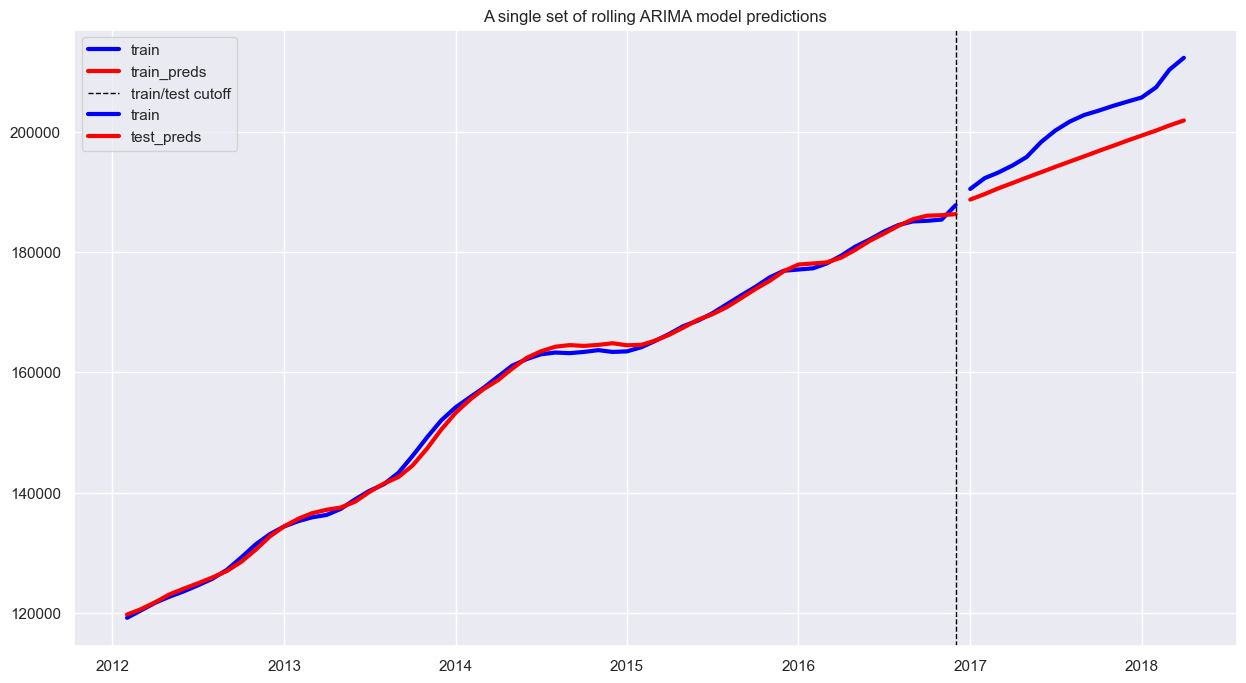

In [33]:
row = arima_model_df.iloc[0]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train', lw='3')
ax.plot(row.train_preds, c='red', label='train_preds', lw='3')
ax.axvline(datetime.datetime(2016, 12, 1), c='black', linewidth=1, linestyle='--', label='train/test cutoff')
ax.plot(row.test, c='blue', label='train', lw='3')
ax.plot(row.test_preds, c='red', label='test_preds', lw='3')
ax.set_title("A single set of rolling ARIMA model predictions")
ax.legend();

# Rolling ARIMA models – last three forecasts only
# (1, 1, 1)

Now that we have determined a rolling ARIMA model to be the better of the two ARIMA models when it comes to overfitting, we will train this model to *all* the available data, to give us better quality predictions.

In [34]:
st = time.time()

trains, predictions = [], []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    train = ad_2012[ad_2012.zipcode==zc].value
    trains.append(train[1:])
    
    for x in range(3):
        
        # Instantiates, trains, and fits model.
        model = ARIMA(train, order=(1, 1, 1)).fit()
        
        # Makes a prediction and appends it to the training dataset.
        # The model will be re-trained on this updated dataset
        # in the next loop iteration, before making its next prediction.
        forecast = model.get_forecast(steps=1).predicted_mean
        train = pd.concat([train, forecast])
        
        # Helpful ticker
        clear_output(wait=True)
        print(f"Zipcode: #{i+1}/{ad_2012.zipcode.nunique()}")
        print(f"Rolling model #{x+1}/{3} done.")
        
    # Stores test predictions.
    preds = train[76:]
    predictions.append(preds)
    
# Helpful bit of info
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode: #453/453
Rolling model #3/3 done.
Execution time: 53.19858694076538 seconds


In [35]:
# Uses the results from the loop to make a dataframe for easy analysis.
forecast_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                                 'predictions': predictions,
                                 'train': trains})

forecast_model_df['price_before_investing'] = forecast_model_df['train'].map(lambda x: x[-1])
forecast_model_df['price_after_investing'] = forecast_model_df['predictions'].map(lambda x: x[-1])

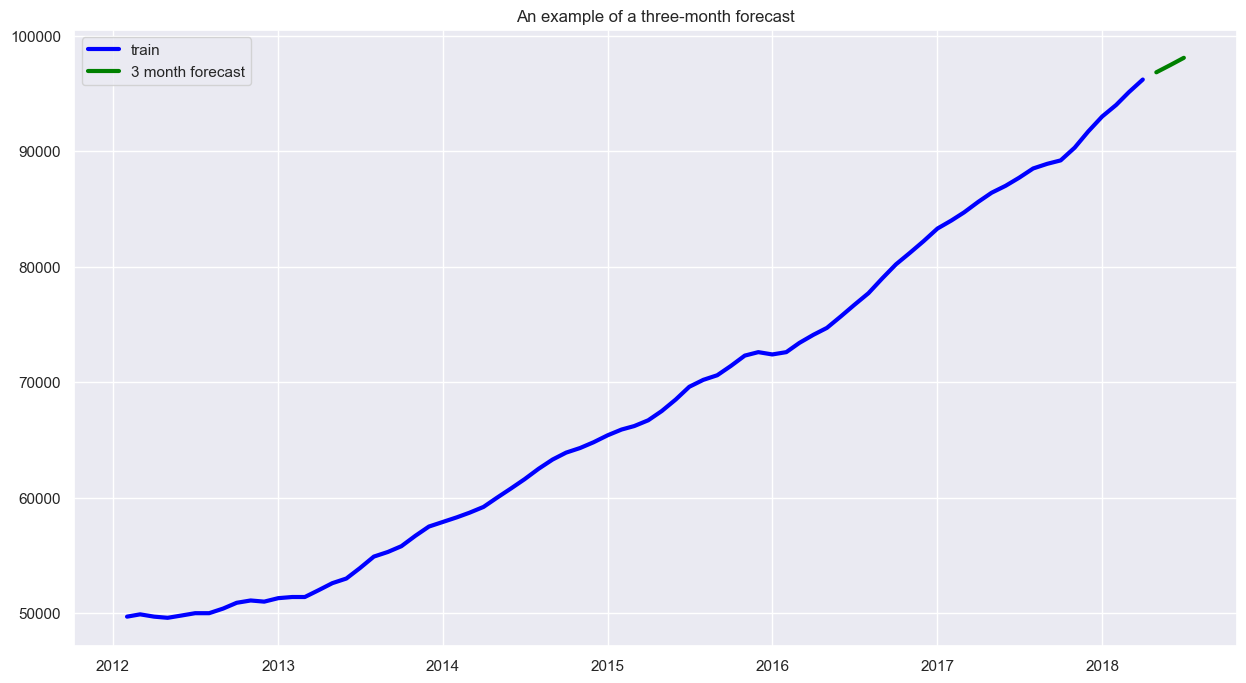

In [36]:
row = forecast_model_df.iloc[1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(row.train, c='blue', label='train', lw='3')
ax.plot(row.predictions, c='green', label='3 month forecast', lw='3')
ax.set_title("An example of a three-month forecast")
ax.legend();

# Calculating expected ROI

We have a model trained on each zipcode that gives a three-month forecast of home price. Using these forecasted prices, we can calculate the expected ROI of an investment made in each zipcode.

In [37]:
rois = []
for i in range(len(forecast_model_df)):
    
    # Divides expected price in three months by the latest recorded price
    increase = forecast_model_df.predictions[i][-1] / forecast_model_df.train[i][-1]
    percentage = (increase - 1) * 100
    percentage_rounded = round(percentage,3)
    rois.append(percentage_rounded)

In [38]:
forecast_model_df['roi'] = rois
forecast_model_df.sort_values(by='roi', ascending=False).head()

,zipcode,predictions,train,price_before_investing,price_after_investing,roi
111,48503,2018-05-01 23580.385734 2018-06-01 23985...,time 2012-02-01 17300.0 2012-03-01 17400...,22800.0,24195.719040,6.122
165,48240,2018-05-01 77446.720854 2018-06-01 78094...,time 2012-02-01 27500.0 2012-03-01 27100...,76800.0,78741.996645,2.529
163,48184,2018-05-01 89732.900061 2018-06-01 90466...,time 2012-02-01 33100.0 2012-03-01 32600...,89000.0,91199.835953,2.472
57,48237,2018-05-01 130631.518825 2018-06-01 1316...,time 2012-02-01 51000.0 2012-03-01 504...,129600.0,132695.201452,2.388
151,48033,2018-05-01 142520.487577 2018-06-01 1436...,time 2012-02-01 56700.0 2012-03-01 571...,141400.0,144761.735864,2.377


# Calculating volatility scores

We now use the volatility scoring function given at the beginning of the notebook to calculate each zipcode's volatility score.

In [39]:
forecast_model_df['volatility'] = forecast_model_df['train'].map(get_volatility)
forecast_model_df.sort_values(by='volatility', ascending=False).head()

,zipcode,predictions,train,price_before_investing,price_after_investing,roi,volatility
433,49129,2018-05-01 352097.386306 2018-06-01 3521...,time 2012-02-01 227400.0 2012-03-01 2249...,352100.0,352126.998057,0.008,117.479295
418,49060,2018-05-01 235208.000563 2018-06-01 2351...,time 2012-02-01 135900.0 2012-03-01 1317...,235200.0,236369.727009,0.497,84.500350
447,49102,2018-05-01 121390.719913 2018-06-01 1214...,time 2012-02-01 110300.0 2012-03-01 1130...,121300.0,121490.681974,0.157,73.262829
443,48897,2018-05-01 105463.975984 2018-06-01 1058...,time 2012-02-01 76600.0 2012-03-01 768...,105100.0,106193.916661,1.041,52.160538
448,49322,2018-05-01 76491.097060 2018-06-01 76479...,time 2012-02-01 62000.0 2012-03-01 61400...,76400.0,76647.341672,0.324,51.585439


# Confirming the effectiveness of the volatility score

If the volatility scoring function actually works, you can expect several things:

- As a zipcode's volatility score goes up, the price action will fluctuate more;
- As a zipcode's volatility score goes up, the expected ROI will become more unpredictable.

Both of the visualizations below confirm this. We see that zipcodes become more and more volatile the higher their volatility score, and as the volatility score increases, the distribution of their ROIs becomes more uniform.

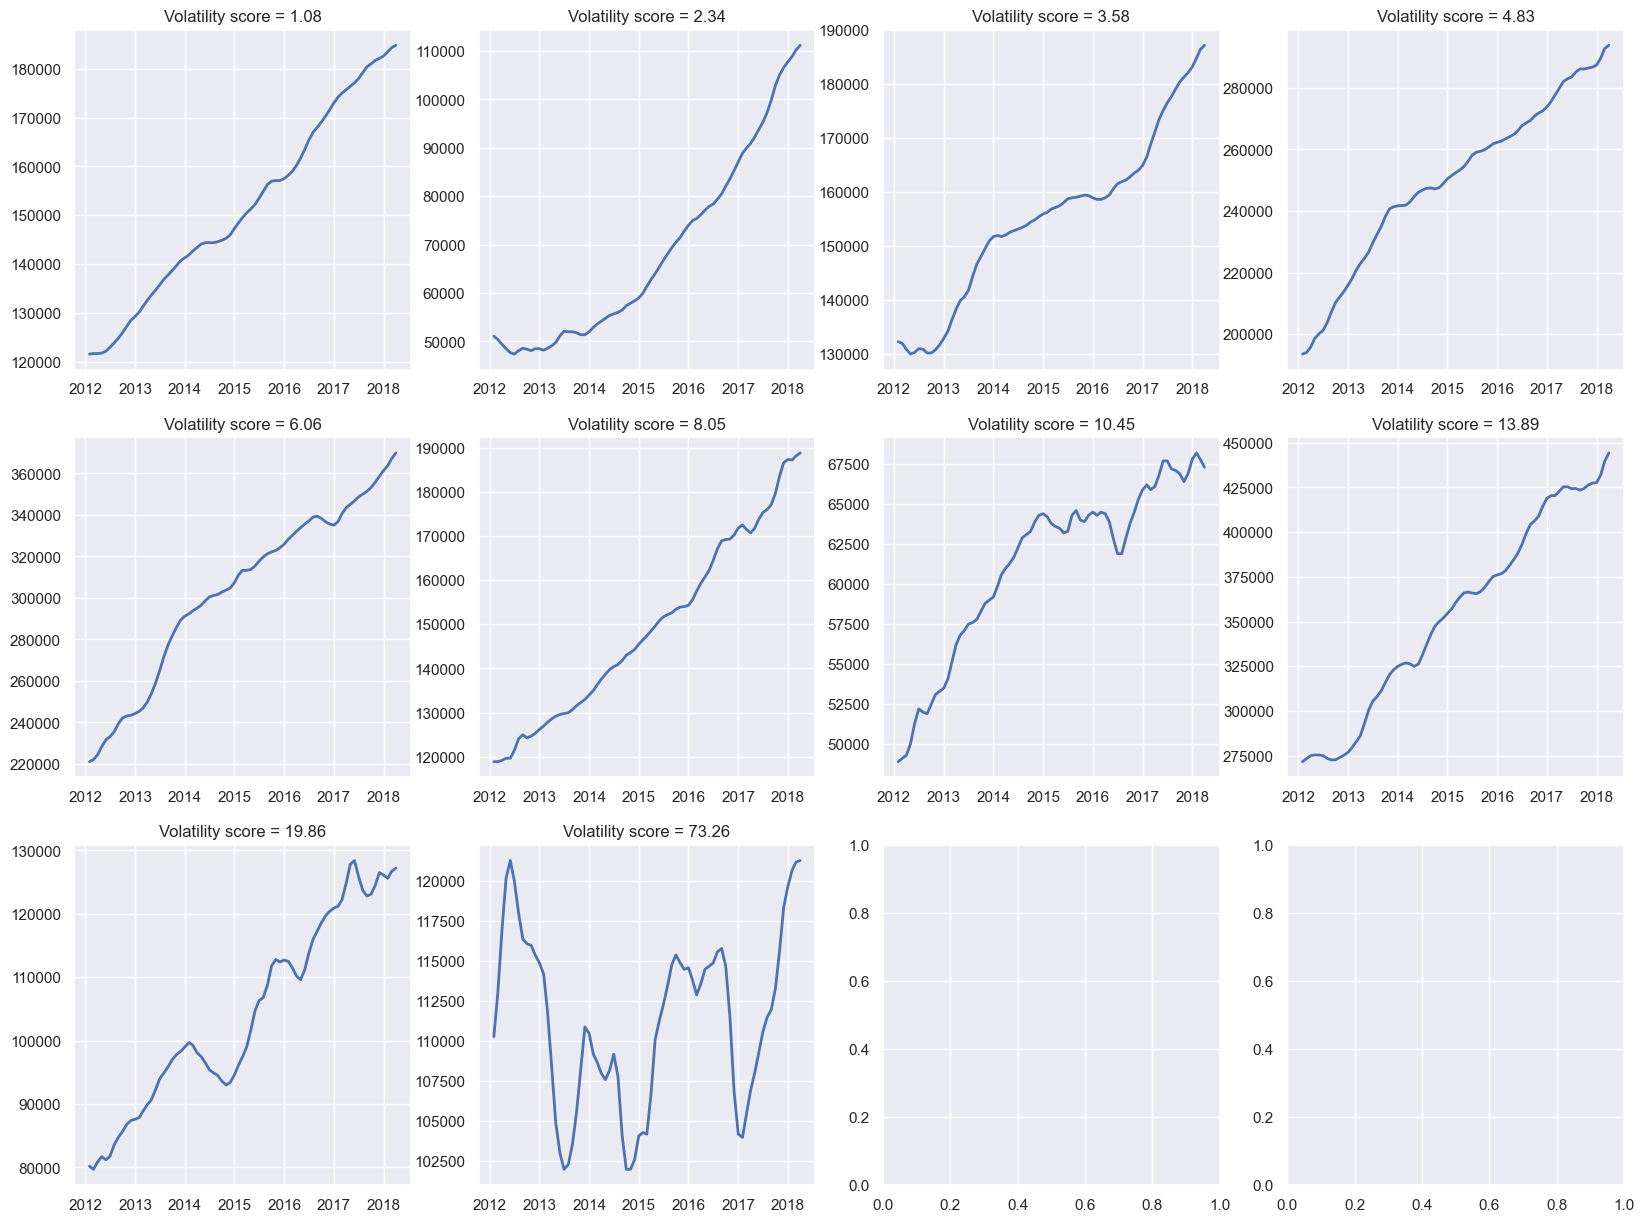

In [40]:
indices = [0,50,100,150,200,250,300,350,400,450]
fig, ax = plt.subplots(3,4, figsize=(20,15))
for i in range(10):
    try:
        index=indices[i]
        row = forecast_model_df.sort_values(by='volatility', ascending=True).iloc[index]
        volatility_score = round(row.volatility, 2)
        prices = row.train
        row = i//4
        col=i%4
        ax[row][col].plot(prices, lw='2')
        ax[row][col].set_title(f"Volatility score = {volatility_score}")
    except:
        pass

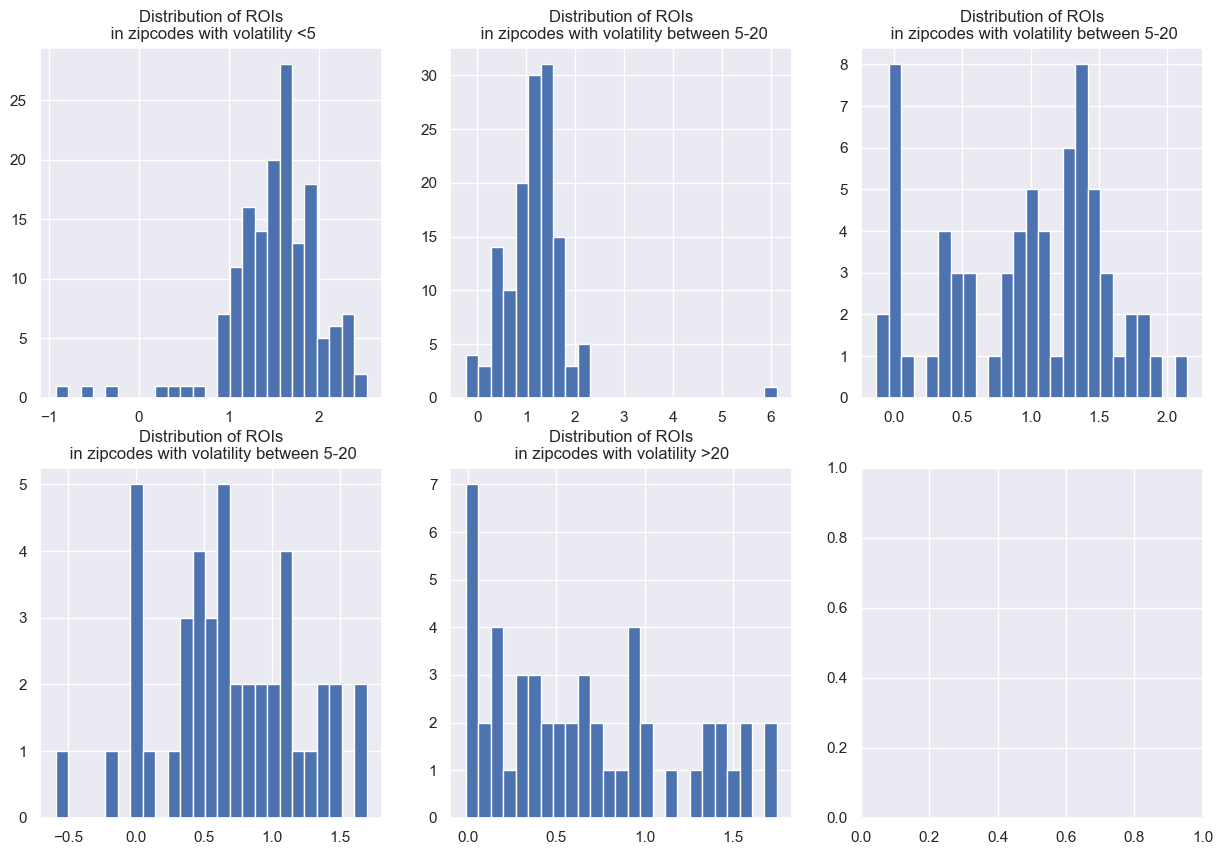

In [41]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

forecast_model_df.query("volatility<5").roi.hist(bins=25, ax=ax[0][0])
forecast_model_df.query("volatility>5 & volatility<10").roi.hist(bins=25, ax=ax[0][1])
forecast_model_df.query("volatility>10 & volatility<15").roi.hist(bins=25, ax=ax[0][2])
forecast_model_df.query("volatility>15 & volatility<20").roi.hist(bins=25, ax=ax[1][0])
forecast_model_df.query("volatility>20").roi.hist(bins=25, ax=ax[1][1])

ax[0][0].set_title("Distribution of ROIs\n in zipcodes with volatility <5")
ax[0][1].set_title("Distribution of ROIs\n in zipcodes with volatility between 5-20")
ax[0][2].set_title("Distribution of ROIs\n in zipcodes with volatility between 5-20")
ax[1][0].set_title("Distribution of ROIs\n in zipcodes with volatility between 5-20")
ax[1][1].set_title("Distribution of ROIs\n in zipcodes with volatility >20 ");

# Selecting a volatility range

We have selected all zipcodes in Michigan with a volatility less than 5. From those zipcodes, we selected the zipcodes with the 5 best expected ROIs, and plotted the three-month price forecast.

In [42]:
five_best_zipcodes = forecast_model_df.query("volatility<=5").sort_values(by='roi', ascending=False)[:5]

In [43]:
five_best_zipcodes

,zipcode,predictions,train,price_before_investing,price_after_investing,roi,volatility
165,48240,2018-05-01 77446.720854 2018-06-01 78094...,time 2012-02-01 27500.0 2012-03-01 27100...,76800.0,78741.996645,2.529,2.351055
163,48184,2018-05-01 89732.900061 2018-06-01 90466...,time 2012-02-01 33100.0 2012-03-01 32600...,89000.0,91199.835953,2.472,1.935624
57,48237,2018-05-01 130631.518825 2018-06-01 1316...,time 2012-02-01 51000.0 2012-03-01 504...,129600.0,132695.201452,2.388,2.371316
151,48033,2018-05-01 142520.487577 2018-06-01 1436...,time 2012-02-01 56700.0 2012-03-01 571...,141400.0,144761.735864,2.377,4.695056
38,48239,2018-05-01 98357.862332 2018-06-01 99116...,time 2012-02-01 40100.0 2012-03-01 39500...,97600.0,99873.927678,2.330,1.521293


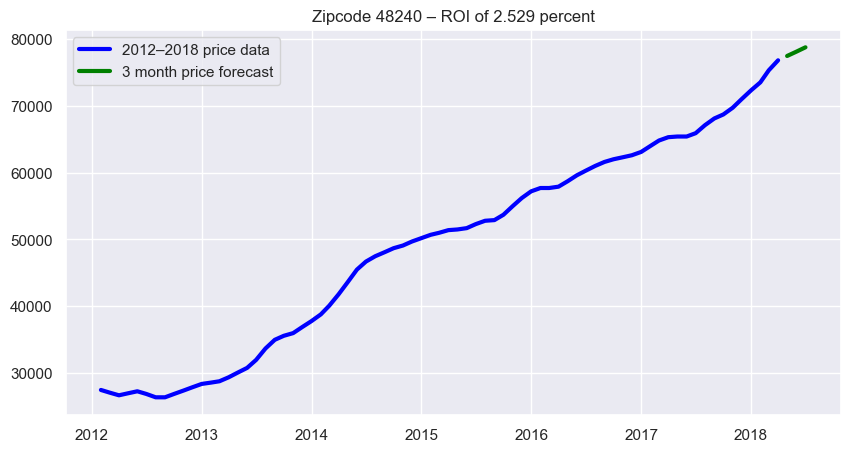

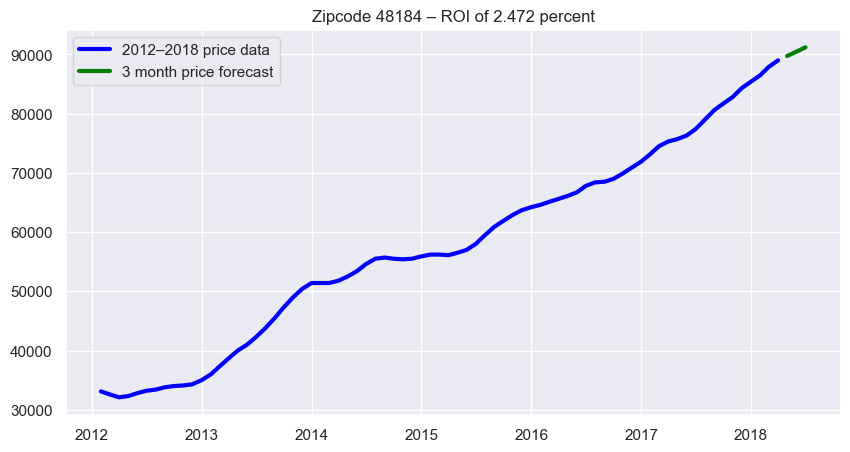

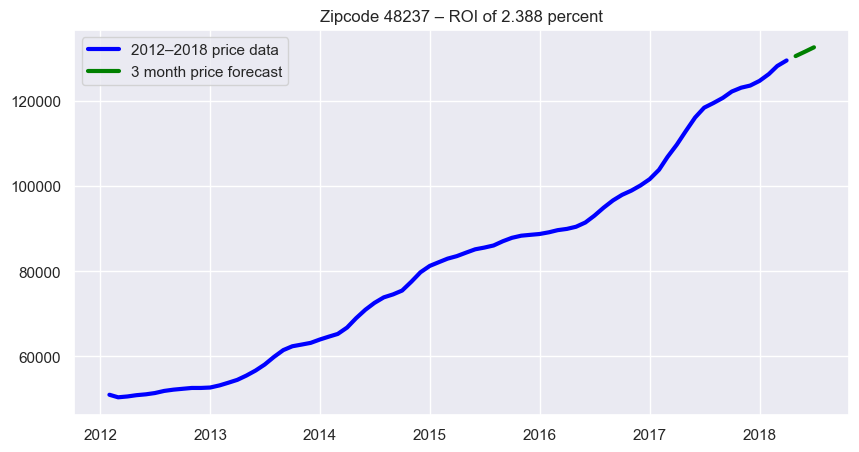

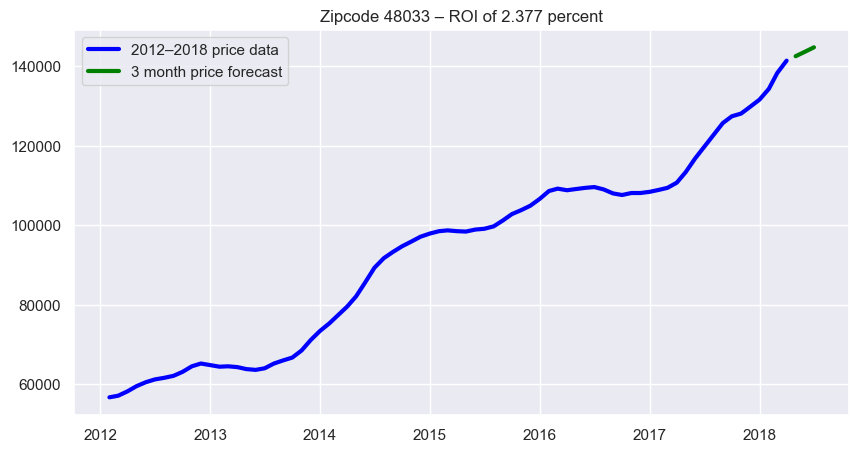

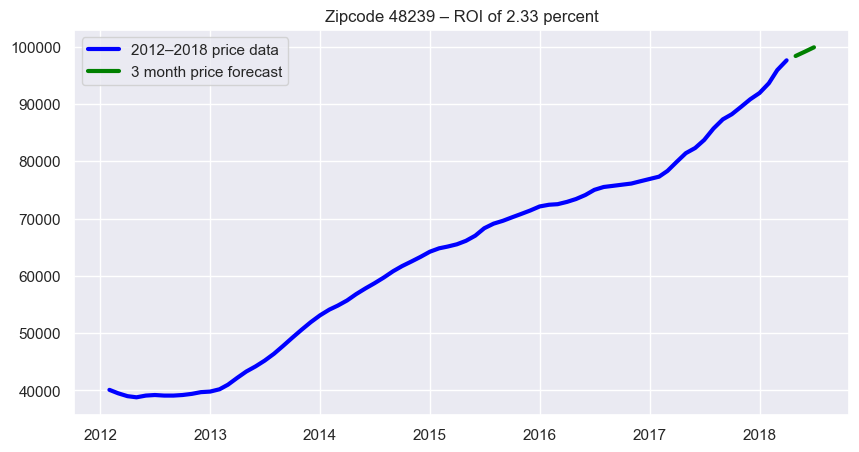

In [44]:
for i in range(len(five_best_zipcodes)):
    row = five_best_zipcodes.iloc[i]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(row.train, c='blue', label='2012–2018 price data', lw='3')
    ax.plot(row.predictions, c='green', label='3 month price forecast', lw='3')
    ax.set_title(f"Zipcode {row.zipcode} – ROI of {row.roi} percent")
    ax.legend();

In [45]:
five_best_zipcodes_dict = {}

for zc in five_best_zipcodes.zipcode:
    
    dataframe = df[df.zipcode==zc]
    row = dataframe.iloc[0]
    city = row.City
    state = row.State
    county = row.CountyName
    mean_price = round(dataframe.value.mean(), 2)
    ROI = five_best_zipcodes.query(f"zipcode=={zc}").iloc[0].roi
    volatility = five_best_zipcodes.query(f"zipcode=={zc}").iloc[0].volatility
    price_before = five_best_zipcodes.query(f"zipcode=={zc}").iloc[0].price_before_investing
    price_after = five_best_zipcodes.query(f"zipcode=={zc}").iloc[0].price_after_investing
    five_best_zipcodes_dict[zc] = [state, county, city, mean_price, volatility, ROI, price_before, price_after]

In [46]:
five_best_zipcodes_formatted = pd.DataFrame(five_best_zipcodes_dict).transpose()
five_best_zipcodes_formatted.columns = ['state', 'county', 'city', 'average_price', 'volatility', 'ROI', 'price_before_investing', 'price_after_investing']
five_best_zipcodes_formatted.index.name = 'zipcode'

# 95% Confidence Intervals for each ROI

We have the projected ROIs for each recommended zipcode, but how close are these projected ROIs to the true ones? To answer this question, we are creating 95% confidence intervals for each projected ROI.

To create these intervals, we start with the knowledge that 95% of observations in a normal distribution fall within two standard deviations of the mean. We know from the distribution below that ROIs from zipcodes with a volatility score <5 are approximately normally distributed. So we took the standard deviation of ROIs in this group, multiplied it by 2, and created an upper/lower bound using that number.

In [47]:
print(f"The standard deviation of all ROIs in zipcodes with volatility <5 is {forecast_model_df.query('volatility<5').roi.std()}.")

The standard deviation of all ROIs in zipcodes with volatility <5 is 0.5094026191880217.


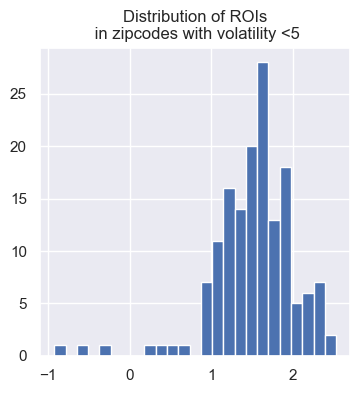

In [48]:
forecast_model_df.query("volatility<5").roi.hist(bins=25, figsize=(4,4))
plt.title("Distribution of ROIs\n in zipcodes with volatility <5");

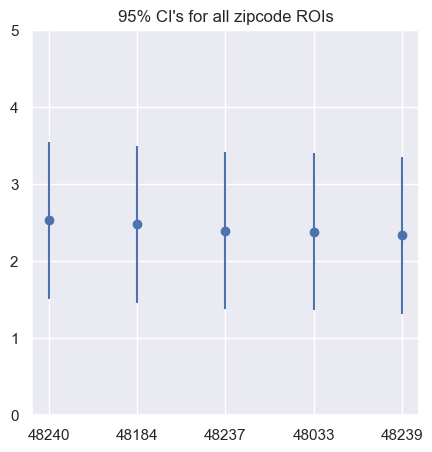

In [49]:
# 95% of values in a normal distribution are within 2 standard deviations
# of the mean.
#
# Since the ROIs of zipcodes with volatility<5 are normally distributed,
# I took the standard deviation of those ROIs, and used it to create the 
# 95% confidence intervals.

std = forecast_model_df.query("volatility<=5").roi.std()

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(0, 5)
x = five_best_zipcodes_formatted.index.astype('str')
y = five_best_zipcodes_formatted.ROI
c = [std*2,std*2,std*2,std*2,std*2]
ax.errorbar(x, y, yerr=c, fmt="o")
ax.set_title("95% CI's for all zipcode ROIs");

# Recommendations

We recommend that our stakeholder make their investments in the zipcodes below. For each zipcode, you will see the state, county, and city of that zipcode, as well as the average price of homes there, the volatility score of that zipcode, and the expected ROI.

In [50]:
five_best_zipcodes_formatted

,state,county,city,average_price,volatility,ROI,price_before_investing,price_after_investing
zipcode,,,,,,,,
48240,MI,Wayne,Redford,78767.92,2.351055,2.529,76800.0,78741.996645
48184,MI,Wayne,Wayne,82427.55,1.935624,2.472,89000.0,91199.835953
48237,MI,Oakland,Oak Park,101081.51,2.371316,2.388,129600.0,132695.201452
48033,MI,Oakland,Southfield,120122.26,4.695056,2.377,141400.0,144761.735864
48239,MI,Wayne,Redford,92205.28,1.521293,2.33,97600.0,99873.927678
